In [1]:
import re
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment

from wordcloud import WordCloud


plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

from env import *
from acquire import *
from prepare import *

## 1. Spam Data

### a. Load the spam data set

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [94]:
class NLP_explore():
    '''Explores some plots and other features and frequencies, bigrams of 
    two selected comparisons within a dataframe based on a specific label
    '''
    def __init__(self, data, label_col:str, text_col:str, c1:str, c2:str):
        '''Pass df, label_col (what is the category), text_col is
        where the text is located, and c1 & c2 are the comparison strings
        '''
        df = data.copy(deep=True)
        # Create all class attributes
        self.label_col = label_col
        self.text_col = text_col
        # Create new instance from orginial
        self.df = data.copy()
        # Comparison 1
        self.c1 = c1
        # Comparison 2
        self.c2 = c2
        
        # Clean the text
        # This is where you'd apply the cleaning for all data
        self.df[text_col] = self.df.text.apply(basic_clean)
        
        # Select comparison 1 from the labeled column
        self.comp1 = df[df[label_col] == c1][text_col]
        # Select comparison 2 from the labeled column
        self.comp2 = df[df[label_col] == c2][text_col]
        # Joined text from comparison 1
        self.w1 = self.comp1.str.cat(sep=' ')
        # Joined text from comparison 2
        self.w2 = self.comp2.str.cat(sep=' ')
        # All cleaned words combined
        self.all_words = f'{self.w1} {self.w2}'        
        
        # Calculates cond1 frequencies
        self.cond1_freq = pd.Series(self.w1.split()).value_counts()
        # Calculates cond2 frequencies
        self.cond2_freq = pd.Series(self.w2.split()).value_counts()
        # Calculates all word frequencies
        self.all_freq = pd.Series(self.all_words.split()).value_counts()
        
        # Creates attribute of word_counts to view the word counts
        # for the condition
        word_counts = pd.concat(
            [self.cond1_freq,
             self.cond2_freq,
             self.all_freq],
            axis=1).fillna(0).astype(int)
        word_counts.columns=[c1, c2, 'all']
        # Make word_counts a feature
        self.word_counts = word_counts
                       
        
    # Create method to plot a horizontal plot for the frequencies
    def hplot_word_freq_viz(self, n=20, sort='all', asc=False):
        '''Takes n which is the number of top values you'd like to plot
        and a sort col, default is 'all', ascending defaults to False
        '''
        plt.rc('font', size=18)
        self.word_counts.\
            sort_values(sort, ascending=asc
                       ).head(n)[[self.c1, self.c2]].plot.barh()
        plt.title(f'''{self.c1.capitalize()} vs {self.c2.capitalize()} count for the top {n} most frequent words''')
        plt.xlabel('Count')
        plt.show()
        
        return
        
    # Create method to stacked barplot for word counts
    def stacked_bplot_freq(self, n=20, sort='all', asc=False):
        '''Takes n which is the number of top values you'd like to plot
        and a sort col, default is 'all', ascending defaults to False
        plots a stacked barchart plot
        '''
        plt.figure(figsize=(16, 9))
        plt.rc('font', size=16)

        (self.word_counts.sort_values(sort, ascending=asc)
         .head(n)
         .apply(lambda row: row/row['all'], axis = 1)
         .drop(columns = 'all')
         .sort_values(by = self.c1)
         .plot.barh(stacked = True, width = 1, ec = 'k')
        )
        plt.title(f'''% of {self.c1.capitalize()} vs {self.c2.capitalize()} count for the top {n} most frequent words''')
        plt.xlabel('Percentage')
        plt.show()
        
        return
    
    # Create method to plot a horizontal plot for the bigrams
    def n_gram(self, col='all', n=2, top_n=20, asc=False):
        '''Takes n which is the number of top values you'd like to pull from the 
        bigram and then you plot those pairs on a horizontal plot 
        default is 'all', ascending defaults to False
        '''
        # generates bigrams which are combinations of two words 
        # throughout the string
        
        # Condition 1 bigrams
        if col == self.c1:
            grams = list(nltk.ngrams(self.w1.split(), n))
        # Condition 2 bigrams
        elif col == self.c2:
            grams = list(nltk.ngrams(self.w2.split(), n))
        # If all or not in the conditions go to all
        else:
            grams = list(nltk.ngrams(self.all_words.split(), n))
            
        
        # Plot the bigrams
        pd.Series(grams).value_counts().head(n).plot.barh()
        # Set the title
        plt.title(f'Top {top_n} most common {col.capitalize()} {n}_grams')
        # Label the x axis with count
        plt.xlabel('Count')
        # Show plot
        plt.show()
        
        # Return the bigram for that selected column
        return bigrams
    
    # Create wordcloud plot based on condition
    def plot_wordcloud(self, col='all', save=False):
        '''Allows for a wordcloud to be plotted from the 'col' of text
        '''
        # Condition 1 words
        if col == self.c1:
            words = self.w1
        # Condition 2 words
        elif col == self.c2:
            words = self.w2
        # If all or not in the conditions go to all
        else:
            words = self.all_words
            
        img = WordCloud(background_color='white', width=800, height=600).generate(words)
        plt.imshow(img)
        plt.axis('off')
        # If save = True, then save the image
        if save:
                plt.savefig(f'images/wordcloud.png')
        
        return
    
    # Adds sentiment analysis to the instance dataframe
    def add_sentiment_analysis(self, cols=['neg', 'neu', 'pos', 'compound']):
        '''Calculates sentiment analysis scores for all columns by
        default, remove names as desired
        cols = ['neg', 'neu', 'pos', 'compound']
        '''
        # Create the Sentiment Analyzer
        sia = nltk.sentiment.SentimentIntensityAnalyzer()
        
        # Iterate though each row
        def fetch_sentiment(row):
            '''Takes a row from dataframe that has text and returns the SentimentIntensityAnalyzer 
            for that text
            '''
            # Stores sentiment results to check with desired cols
            sentiment_dict = sia.polarity_scores(row[self.text_col])
            
            # Returns only the desired columns from the dictonary
            return [sentiment_dict[i] for i in cols if i in sentiment_dict]
        
        # Apply and expand columns with the results from the sentiment analysis and selected columns
        self.df[cols] = self.df.apply(fetch_sentiment, axis=1, result_type='expand')
    
        return self.df
            

    def add_features(self, features=[
        'message_length',
        'word_count',
        'unique_word_count',
        'avg_word_len'
    ]):
        
        '''These are all the features that can be added to the dataframe
        default = [
        'message_length', word_count', 'unique_word_count','avg_word_len'
        ]
        '''
        
        def calculate_feature(row):
            '''Goes through the dict of values that need to be added 
            and puts them into a dict, and then returns it on a row-by-row
            basis
            '''
            # The dict to be queried at the end as a placeholder
            result = dict()
            
            # Tabulates all features then adds only the ones desired at
            # the end.
            txt = row[self.text_col] # Pulls the text out of the row
            
            # Put the text into a panda Series for easier tabulations
            s = pd.Series(txt.split(), dtype = 'object')
            
            # Tabulate message length via sum of the all text and chars
            result['message_length'] = len(txt)
            
            # Tabulate word count row wise
            result['word_count'] = s.size
            
            # Tabulate unique word count take unique value counts
            result['unique_word_count'] = s.value_counts().to_dict()
            
            # Tabulate avgerage word length per row by taking total sum, without whitespace / total word count
            try: # Need to ensure we do not divide by zero
                avg = result['message_length'] / result['word_count']
            except: # If divide by zero error, set avg to zero
                avg = 0
            result['avg_word_len'] = round(avg, 2)

            # Filter any features not desired
            return [result[i] for i in features if i in result]
        
        # Apply and expand columns with the results from the all_calculated features and selected columns
        self.df[features] = self.df.apply(calculate_feature, axis=1, result_type='expand')
        
        return self.df
    
    def sentiment_bivariate_plots(self, sentiments=['compound'],
                                  features=['message_length','word_count', 'avg_word_len'],
                                  save=False, alpha=0.5, levels=30):
        '''Takes sentiment columns as a list and feature columns as a list and plots each comb
        default sentiment is ['compound']
        default features are = [
        'message_length', word_count', 'avg_word_len']
        default alpha = 0.5
        default levels = 30
        default save = False

        '''
        comp1 = self.c1
        comp2 = self.c2
        comp1_df = self.df[self.df[self.label_col] == comp1]
        comp2_df = self.df[self.df[self.label_col] == comp2]
        # Iterate through features
        for feature in features:
            # Iterate though sentiments
            for sentiment in sentiments:
                filename = f'images/{feature}_vs_{sentiment}'
                
                
                # Bivariate KDE plot for Comparison 1 first
                sns.kdeplot(x= comp1_df[feature], 
                            y= comp1_df[sentiment],
                            levels = levels, shade = True, label=f'{comp1.title()}'
                           ).set(title=f'{feature.title()} vs {sentiment.title()} for {comp1}')
                # Then comparison 2
                sns.kdeplot(x= comp2_df[feature], 
                            y= comp2_df[sentiment],
                            levels = levels, shade = True, label=f'{comp2.title()}'
                           ).set(title=f'{feature.title()} vs {sentiment.title()} for {comp2}')
                plt.legend()
                plt.show()
                
                # If save = True, then save the image
                if save:
                    plt.savefig(filename+'_KDE.png')
                
                # Plot scatterplot
                sns.relplot(
                    data = self.df, x = feature,
                    y = sentiment, hue = self.label_col).set(title=f'{feature.title()} vs {sentiment.title()}')
                plt.legend()
                plt.show()
                
                # If save = True, then save the image
                if save:
                    plt.savefig(filename+'_scatter.png')
                
    def sentiment_distributions(self, sentiments=['neg', 'neu', 'pos', 'compound'], save=False):
        '''Takes sentiment columns as a list and feature columns as a list and plots each comb
        default sentiment is ['neg', 'neu', 'pos', 'compound']
        '''
        # Iterate though sentiments
        for sentiment in sentiments:
            comp1_df = self.df[self.df[self.label_col] == self.c1]
            comp2_df = self.df[self.df[self.label_col] == self.c2]

            # Plot Dist for Comparison 1 first
            sns.kdeplot(comp1_df[sentiment], label = self.c1.title())
            # Then plot Dist for Comp 2
            sns.kdeplot(comp2_df[sentiment], label = self.c2.title())
            plt.legend()
            plt.show()
            
            # If save = True, then save the image
            if save:
                plt.savefig(f'images/{sentiment}_dist.png')
        
        
        

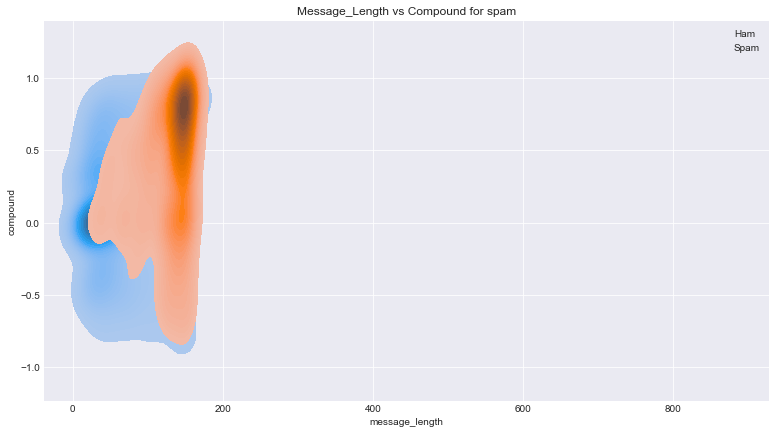

<Figure size 936x504 with 0 Axes>

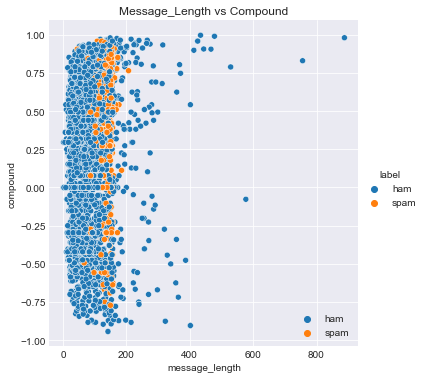

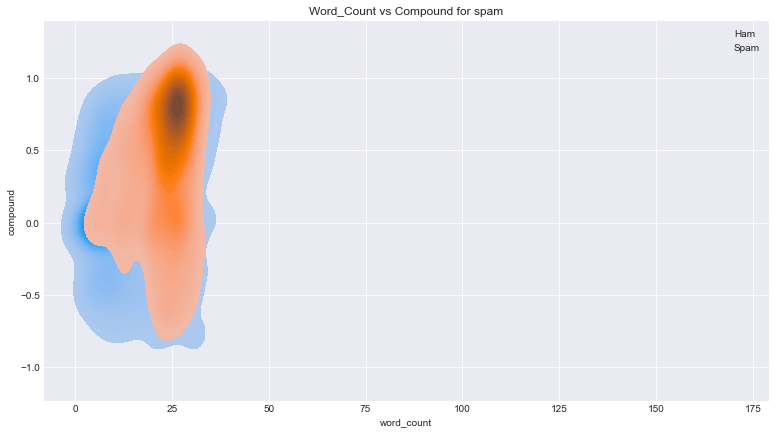

In [ ]:
hns = NLP_explore(df, 'label', 'text', 'ham', 'spam')
hns.add_features()
hns.add_sentiment_analysis().head()
hns.sentiment_bivariate_plots(save=True)
hns.sentiment_distributions(save=True)
hns.plot_wordcloud(save=True)

In [ ]:
hns.stacked_bplot_freq()

### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [ ]:
# combine all messages in single string by label

ham_words = build_word_count_df(df[df.label == 'ham'])
spam_words = basic_clean(' '.join(df[df.label == 'spam'].text))
all_words = basic_clean(' '.join(df.text))

In [ ]:
ham_freq = pd.Series(ham_words.split()).value_counts()
spam_freq = pd.Series(spam_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

spam_freq.head(6)

In [ ]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['ham', 'spam', 'all']
word_counts.head()

### c. Is there any overlap in the bigrams for the spam data and the ham data?

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the `category` variable when exploring.